In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
from scipy.stats import binned_statistic, powerlaw, binned_statistic_2d
from scipy.interpolate import interp1d
import kmeans_radec
import seaborn
from astropy.io import ascii


import Setup as p
import SelectionFunc

/mnt/zfsusers/rstiskalek/src/Code/SelectionFunc.py:150: RuntimeWarning: overflow encountered in exp
  return -np.exp(a*x+b) + c*x + d
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [2]:
data = fits.open("../../BAM/a100springfull.fits")[1].data

# Unpack all the values
RA = data['RAdeg_HI']
DEC = data['DECdeg_HI']
dist = data['Dist']
logMH = data['logMH']
MS = data['SERSIC_MASS']
apmag = data['petroMag_r']

# Take only the ones with finite SM
IDS = np.where(np.isfinite(MS))
RA = RA[IDS]
DEC = DEC[IDS]
dist = dist[IDS]
logMH = logMH[IDS]
logMS = np.log10(MS[IDS])
apmag = data['petroMag_r'][IDS]

[8.245922134925959, 8.990324401288419, 9.473257810423036]
9324.0
7253.999999999999
5180.0


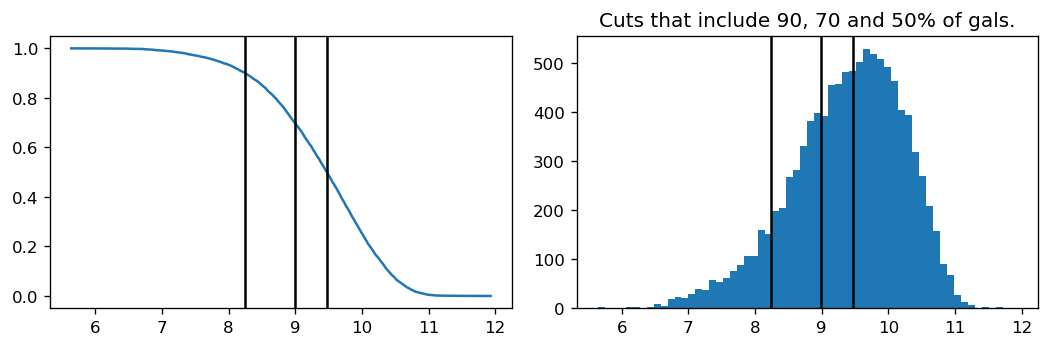

In [4]:
t = np.linspace(logMS.min(), logMS.max(),1000)

def func(masscut):
    return np.where(logMS>masscut)[0].size/logMS.size

y = interp1d(np.array([func(i) for i in t]), t)

perc_list = [0.9, 0.7, 0.5]
cuts = [float(y(i)) for i in perc_list]

cuts_def = {perc_list[0] : cuts[0],
           perc_list[1] : cuts[1],
           perc_list[2] : cuts[2]}

p.dump_pickle(cuts_def, "../../Data/SMmatching/logMScuts_def.p")
print(cuts)



t = np.linspace(logMS.min(), logMS.max(),1000)

plt.figure(dpi=120, figsize=(9, 3))

plt.subplot(121)
plt.plot(t, [func(i) for i in t])
for c in cuts:
    plt.axvline(c, c='black')
    print(func(c)*logMS.size)


plt.subplot(122)
plt.hist(logMS, bins='auto')
plt.title("Cuts that include 90, 70 and 50% of gals.")
for c in cuts:
    plt.axvline(c, c='black')

plt.tight_layout()
plt.show()


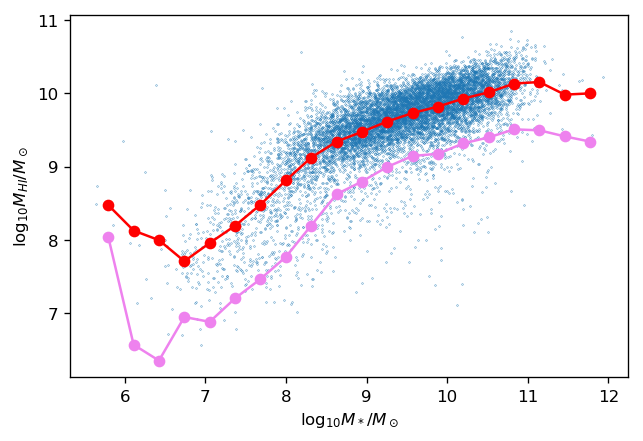

In [5]:
N = 20
stat, bin_edges, __ = binned_statistic(logMS, logMH, bins=N, statistic=np.mean)
statstd, bin_edges, __ = binned_statistic(logMS, logMH, bins=N, statistic=np.std)

bin_centers = p.bin_centers(bin_edges)

lowbound = stat-2*statstd

MS2MHI_func = interp1d(bin_centers, lowbound)


plt.figure(dpi=120)
plt.scatter(logMS, logMH, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, lowbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_*/M_\odot$")
plt.ylabel(r"$\log_{10}M_{HI}/M_\odot$")
plt.show()

In [6]:
def func_absmag(appmag, d):
    # Distance in Mpc
    return appmag-25-5*np.log10(d)

absmag = list()
for i, j in zip(apmag, dist):
    absmag.append(func_absmag(i, j))
absmag = np.array(absmag)

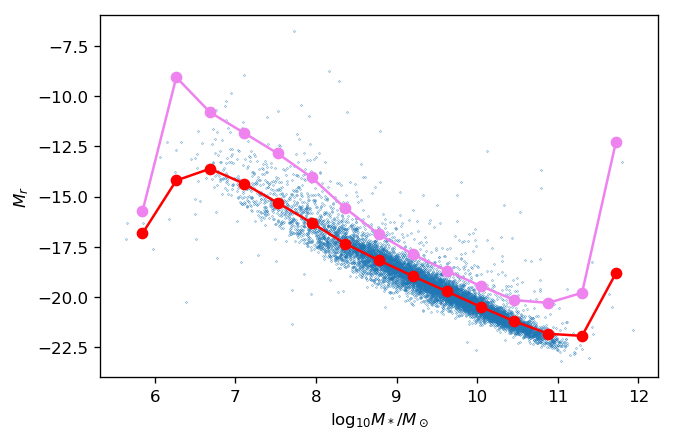

In [7]:
stat, bin_edges, __ = binned_statistic(logMS, absmag, bins=15)
statstd, bin_edges, __ = binned_statistic(logMS, absmag, bins=15, statistic=np.std)
bin_centers = p.bin_centers(bin_edges)

upperbound = stat+2*statstd

MS2absmag_func = interp1d(bin_centers, upperbound)

plt.figure(dpi=120)
plt.scatter(logMS, absmag, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, upperbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_*/M_\odot$")
plt.ylabel(r"$M_r$")
plt.show()

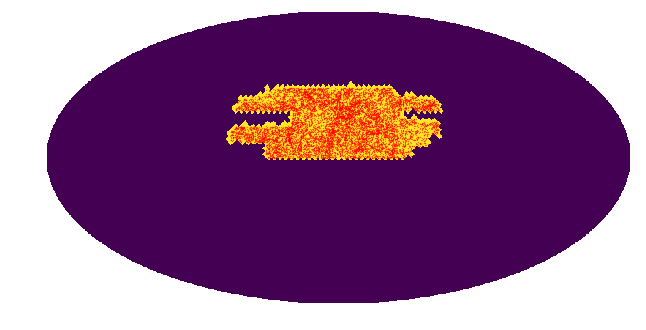

In [8]:
# Get pixel coverage for the random catalog
nside=25
hpmap = np.zeros(hp.nside2npix(nside))
active_pixs = list()
for r, d in zip(np.deg2rad(RA), np.deg2rad(DEC)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    hpmap[pix] = 1
    active_pixs.append(pix)
    
hp.mollview(hpmap, rot=180, cbar=False, title='')
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.05, c='red')

active_pixs = np.unique(np.array(active_pixs))

logMSlim 9.473257810423036
logMHIlim 9.098315378714357 absmaglim -18.40511925621473


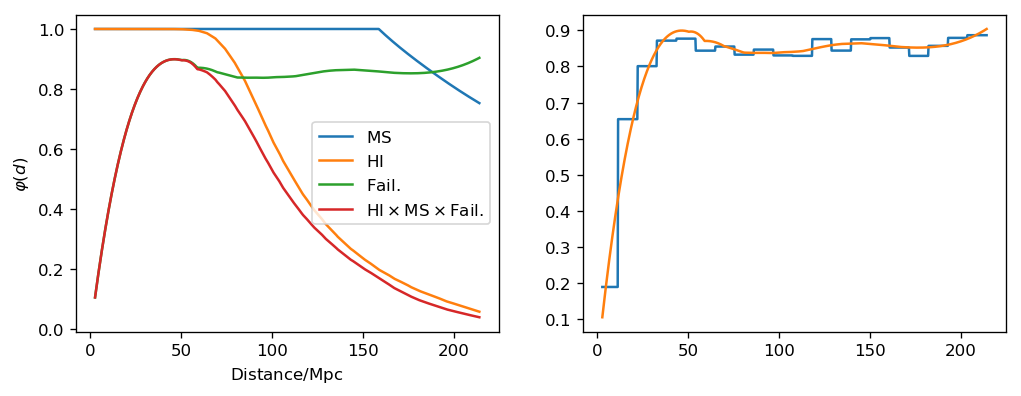

In [20]:
# Generate an appropriate selection function
num = 2
logMSlim = cuts[num]
perc = perc_list[num]

print("logMSlim", logMSlim)
logMHlim = MS2MHI_func(logMSlim)
absmaglim = MS2absmag_func(logMSlim)
print("logMHIlim", logMHlim, "absmaglim", absmaglim)

dist_arr = np.linspace(dist.min(), dist.max(), 1000)

y1 = SelectionFunc.survival_func_HI(dist_arr, logMHlim, 151)(dist_arr)
y2coarse, y2smooth, y2func = SelectionFunc.survival_rate(dist_arr, logMHlim, logMH.max(), 451, 3)
y2 = y2func(dist_arr)
y3 = SelectionFunc.survival_func_SM(dist_arr, absmaglim)(dist_arr)

y = y1*y2*y3
surv_func = interp1d(dist_arr, y)
# plt.figure(figsize=(figwidth, figheight) ,dpi=240)
plt.figure(dpi=120, figsize=(10,3.5))

plt.subplot(121)
plt.plot(dist_arr, y3, label=r"$\mathrm{MS}$")
plt.plot(dist_arr, y1, label=r"$\mathrm{HI}$")
plt.plot(dist_arr, y2, label=r"$\mathrm{Fail.}$")
plt.plot(dist_arr, y, label=r"$\mathrm{HI}\times\mathrm{MS}\times \mathrm{Fail.}$")
plt.ylabel(r"$\varphi(d)$")
plt.xlabel(r"$\mathrm{Distance}/\mathrm{Mpc}$")
plt.legend()

plt.subplot(122)
plt.plot(dist_arr, y2coarse)
plt.plot(dist_arr, y2smooth)

plt.show()

4891149
1013153


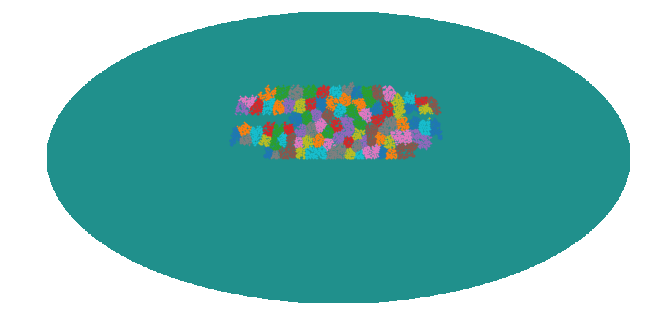

In [21]:
# Generate a random catalog
Nrands = 5e6
Nrands_target = int(Nrands/0.75)
RAmin, RAmax = np.deg2rad(RA.min()), np.deg2rad(RA.max())
Pmin = (np.sin(np.deg2rad(DEC.min()))+1)/2
Pmax = (np.sin(np.deg2rad(DEC.max()))+1)/2
distmin, distmax = dist.min(), dist.max()

randRA = np.random.uniform(RAmin, RAmax, Nrands_target)
randDEC = np.arcsin(2*np.random.uniform(Pmin, Pmax, size=Nrands_target)-1)
randdist = powerlaw.rvs(a=3, loc=distmin, scale=distmax-distmin, size=Nrands_target)

# Eliminate galaxies in pixels not covered by the ALFALFA survey
pixels = hp.ang2pix(p.nside, np.pi/2-randDEC, randRA)
IDS = np.where(np.isin(pixels, active_pixs)==True)
# Switch to degrees
randRA= np.rad2deg(randRA[IDS])
randDEC = np.rad2deg(randDEC[IDS])
randdist = randdist[IDS]

# Cluster the galaxies for jackknifing
N = randRA.size
Ncluster = 10000
IDS = np.random.choice(np.arange(N), Ncluster, False)
X = np.vstack([randRA[IDS], randDEC[IDS]]).T
km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

X = np.vstack([randRA, randDEC]).T
randLabels = km.find_nearest(X)

hp.mollview(np.zeros(12), rot=180, title='', cbar=False)
for label in np.unique(km.labels):
    IDSlab = np.where(km.labels==label)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS][IDSlab]), np.deg2rad(randRA[IDS][IDSlab]), s=0.5)
    
# Apply selection effects to the rand.
N = randdist.size
print(N)

prob_surv = surv_func(randdist)
# Don't forget RFI..
hvel = list()
for r, d, distance in zip(np.deg2rad(randRA), np.deg2rad(randDEC), randdist):
    hvel.append(SelectionFunc.heliovelocity([r, d, distance]))
hvel = np.array(hvel)

prob_rfi = SelectionFunc.survival_func_rfi(hvel)
# prob_rfi=1

prob_arr = prob_surv*prob_rfi
rand_arr = np.random.uniform(0, 1, N)

IDS = np.where((prob_arr-rand_arr) > 0)
randdist = randdist[IDS]
randRA = randRA[IDS]
randDEC = randDEC[IDS]
randLabels = randLabels[IDS]
print(randdist.size)

N. gal above this mass cut 5180


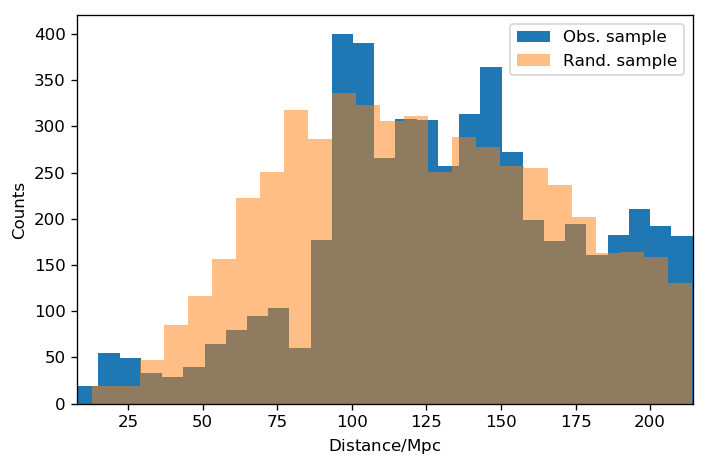

In [22]:
# Plot how do the histograms differ
IDS = np.where(logMS>logMSlim)
print("N. gal above this mass cut", IDS[0].size)


# Downsample randcat to the same size as catalog
IDS2 = np.random.choice(np.arange(randdist.size), dist[IDS].size, replace=False)

# plt.figure(figsize=(figwidth, figheight) ,dpi=240)
plt.figure(dpi=120)

plt.hist(dist[IDS], bins='auto', label="Obs. sample")
plt.hist(randdist[IDS2], bins='auto', label="Rand. sample", alpha=0.5)
plt.ylabel(r"Counts")
plt.xlabel(r"Distance$/\mathrm{Mpc}$")
plt.xlim(dist[IDS].min(), dist[IDS].max())
plt.legend()
plt.tight_layout()
plt.show()

Number density is 0.010464351035468857


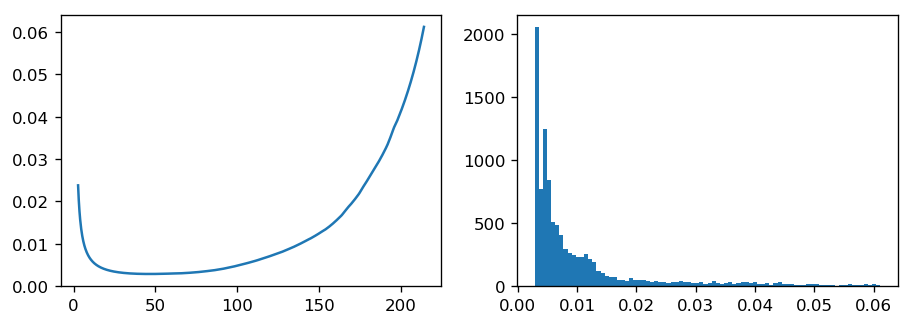

In [23]:
MFWascii = ascii.read("../../Data/HIdata/a100.180315.MWF.csv")
MFW = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

number_density = 0
mlow_ind = np.abs(logMHlim-np.array(massbins)).argmin()

for i in range(len(w50bins)-1):
    dw50 = w50bins[i+1]-w50bins[i]
    w50 = (w50bins[i+1]+w50bins[i])/2

    for j in range(mlow_ind, len(massbins)-1):
        dm = massbins[j+1]-massbins[j]
        number_density += MFW[j, i]*dm*dw50

print("Number density is {}".format(number_density))

J3 = 2962

def get_weights(dist):
    return 1/(1+4*np.pi*number_density*J3*surv_func(dist))

plt.figure(dpi=120, figsize=(9,3))

plt.subplot(121)
plt.plot(dist_arr, get_weights(dist_arr))

plt.subplot(122)
plt.hist(get_weights(dist), bins='auto')

plt.show()

We have 1013153 galaxies in random.
We have 5180 galaxies in observation.


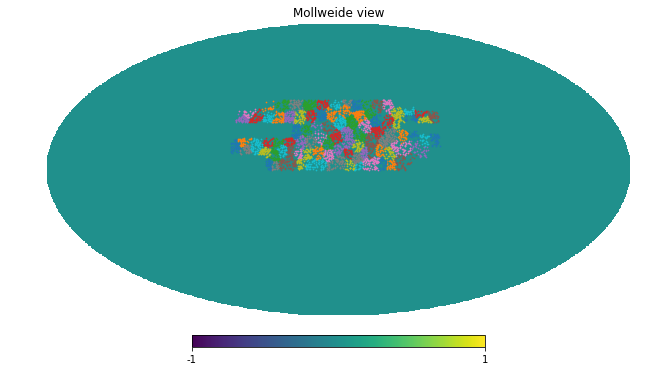

In [24]:
N = randdist.size
random_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'label', 'weights'),
                                'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
random_catalog['ra'] = randRA
random_catalog['dec'] = randDEC
random_catalog['dist'] = randdist
random_catalog['label'] = randLabels
# random_catalog['weights'] = np.ones_like(randRA)
random_catalog['weights'] = get_weights(randdist)

np.save("../../Data/SMmatching/CFrandcatSM_{}_.npy".format(perc), random_catalog)
print("We have {} galaxies in random.".format(N))

IDS = np.where(logMS>logMSlim)
N = dist[IDS].size
X = np.vstack([RA[IDS], DEC[IDS]]).T

cut_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'weights', 'label'),
                                'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
cut_catalog['ra'] = RA[IDS]
cut_catalog['dec'] = DEC[IDS]
cut_catalog['dist'] = dist[IDS]
cut_catalog['weights'] = get_weights(dist[IDS])
cut_catalog['label'] = km.find_nearest(X)
# cut_catalog['weights'] = np.ones_like(RAcut)

np.save("../../Data/SMmatching/CFcatSM_{}_.npy".format(perc), cut_catalog)
print("We have {} galaxies in observation.".format(N))

hp.mollview(np.zeros(12), rot=180)
for label in np.unique(km.labels):
    IDSlab = np.where(label==cut_catalog['label'])
    hp.projscatter(np.pi/2-np.deg2rad(DEC[IDS])[IDSlab], np.deg2rad(RA[IDS])[IDSlab], s=0.5)

In [14]:
!ls ../../Data/SMmatching/

a70_160624.ascii	   km_clusters.p
a70_160624.csv		   LF_Ser.dat
active_pixs.p		   logMScuts_def.p
CFcatSM_0.33_.npy	   Obs_CF_SMcut_0.33_.p
CFcatSM_0.9_.npy	   Obs_CF_SMcut_0.9_.p
CFcatSM_HItestM2_.npy	   Obs_CF_SMcut_HItestM2_.p
CFcatSM_HItest_.npy	   Obs_CF_SMcut_HItest_.p
CFcatSM_SMtestm1_.npy	   Obs_CF_SMcut_SMtestm1_.p
CFcatSM_SMtestm2_.npy	   Obs_CF_SMcut_SMtestm2_.p
CFrandcatSM_0.33_.npy	   randcat.npy
CFrandcatSM_0.9_.npy	   Train_jackknife_covmats_0.5_.p
CFrandcatSM_HItestM2_.npy  Train_jackknife_covmats_0.7_.p
CFrandcatSM_HItest_.npy    Train_stoch_covmats_0.5_.p
CFrandcatSM_SMtestm1_.npy  Train_stoch_covmats_0.7_.p
CFrandcatSM_SMtestm2_.npy  Train_stoch_covmats_0.9_.p
failure_surv.p


STOOOOP

## Method 2: Draw distance and masses from obs. sample

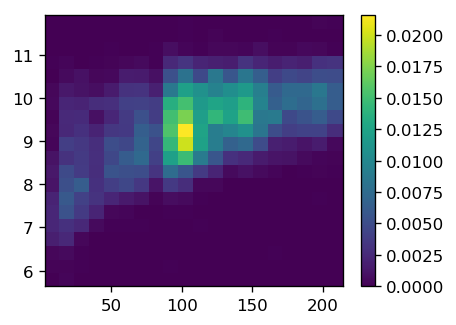

In [28]:
Nbins = 20
x_bins = np.linspace(dist.min(), dist.max(), Nbins+1)
y_bins = np.linspace(logMS.min(), logMS.max(), Nbins+1)


stat = binned_statistic_2d(dist, logMS, values=logMS, statistic='count', bins=[x_bins, y_bins])[0].T
stat = stat/np.sum(stat)
XX, YY = np.meshgrid(x_bins, y_bins)

plt.figure(dpi=120, figsize=(4,3))
plt.pcolor(XX, YY, stat)
plt.colorbar()
plt.show()

In [30]:
xcent = p.bin_centers(x_bins)
ycent = p.bin_centers(y_bins)

def stat_interp(dist, mass):
    xi = np.abs(xcent-dist).argmin()
    yi = np.abs(ycent-mass).argmin()
    return stat[yi, xi]



mindist = dist.min()
maxdist = dist.max()
minlogMS = logMS.min()
maxlogMS = logMS.max()
RAmin, RAmax = np.deg2rad(RA.min()), np.deg2rad(RA.max())
arcsinDECmin, arcsinDECmax = np.arcsin(np.deg2rad(DEC.min())), np.arcsin(np.deg2rad(DEC.max()))

def get_random():
    while True:
        rand_dist = powerlaw.rvs(a=3, loc=mindist, scale=(maxdist-mindist))
#         rand_dist = np.random.uniform(mindist, maxdist)
        rand_mass = np.random.uniform(minlogMS, maxlogMS)
        rand_prob = np.random.uniform()
        keep_prob = stat_interp(rand_dist, rand_mass)
        if keep_prob > rand_prob:
            while True:
                rand_RA = np.rad2deg(np.random.uniform(RAmin, RAmax))
                rand_DEC = np.rad2deg(np.arcsin(np.random.uniform(arcsinDECmin, arcsinDECmax)))
                pix = hp.ang2pix(nside, np.pi/2-np.deg2rad(rand_DEC), np.deg2rad(rand_RA))
                if pix in active_pixs:
                    return rand_RA, rand_DEC, rand_dist, rand_mass

        
# # Generate everything!
# Ntest = 100000
# randlogMS = np.zeros(Ntest)
# randRA = np.zeros(Ntest)
# randDEC = np.zeros(Ntest)
# randdist = np.zeros(Ntest)


# # TO DO: make this tqdmrange to see progress
# for i in range(Ntest):
#     rand_RAi, rand_DECi, rand_disti, rand_massi = get_random()
#     randlogMS[i] = rand_massi
#     randdist[i] = rand_disti
#     randRA[i] = rand_RAi
#     randDEC[i] = rand_DECi
    
# # Cluster the galaxies for jackknifing
# N = randRA.size
# Ncluster = 10000
# IDS = np.random.choice(np.arange(N), Ncluster, False)
# X = np.vstack([randRA[IDS], randDEC[IDS]]).T
# km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

# X = np.vstack([randRA, randDEC]).T
# randLabels = km.find_nearest(X)

In [ ]:
stat_rand = binned_statistic_2d(randdist, randlogMS, values=randlogMS, statistic='count',
                                bins=[x_bins, y_bins])[0].T

plt.figure(dpi=120, figsize=(10, 8))

plt.subplot(221)
plt.hist(dist, bins='auto', label='obs', density=1)
plt.hist(randdist, bins='auto', density=1, label='rand', alpha=0.5)
plt.legend()

plt.subplot(222)
plt.hist(logMS, bins='auto', label='obs', density=1)
plt.hist(randlogMS, bins='auto', density=1, label='rand', alpha=0.5)
plt.legend()

plt.subplot(223)
plt.pcolor(XX, YY, stat_rand)
plt.colorbar()

plt.show()


hp.mollview(np.zeros(12), rot=180, cbar=False, title='')
for label in np.unique(km.labels):
    IDS = np.where(randLabels == label)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS]), np.deg2rad(randRA[IDS]), s=0.05)
plt.show()

In [ ]:
perc = "SMtestm2"

IDS = np.where(randlogMS > logMSlim)
N = randdist[IDS].size
print("We have {} galaxies in random.".format(N))

random_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'label', 'weights'),
                                'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
random_catalog['ra'] = randRA[IDS]
random_catalog['dec'] = randDEC[IDS]
random_catalog['dist'] = randdist[IDS]
random_catalog['label'] = randLabels[IDS]
random_catalog['weights'] = get_weights(randdist[IDS])
# random_catalog['weights'] = np.ones_like(randRA[IDS])

np.save("../../Data/SMmatching/CFrandcatSM_{}_.npy".format(perc), random_catalog)

IDS = np.where(logMS>logMSlim)
N = dist[IDS].size
print("We have {} galaxies in observation.".format(N))

cut_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'weights', 'label'),
                                'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
cut_catalog['ra'] = RA[IDS]
cut_catalog['dec'] = DEC[IDS]
cut_catalog['dist'] = dist[IDS]
cut_catalog['label'] = km.find_nearest(X = np.vstack([RA[IDS], DEC[IDS]]).T)
cut_catalog['weights'] = get_weights(dist[IDS])
# cut_catalog['weights'] = np.ones_like(RAcut)

np.save("../../Data/SMmatching/CFcatSM_{}_.npy".format(perc), cut_catalog)

hp.mollview(np.zeros(12), rot=180, cbar=False, title='')
for label in np.unique(km.labels):
    IDSlab = np.where(label==cut_catalog['label'])
    hp.projscatter(np.pi/2-np.deg2rad(DEC[IDS])[IDSlab], np.deg2rad(RA[IDS])[IDSlab], s=0.5)